In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier

In [3]:
features = ['Num_authors_mean',
     'cpy_max',
     'cpy_mean',
     'Productivity',
     'collab_cpy_mean_mean',
     'collab_cpy_mean_max',
     'collab_cpy_max_mean',
     'collab_cpy_max_max']
X = df[features]
y = np.where(df.Label == 'Active', 1, 0)

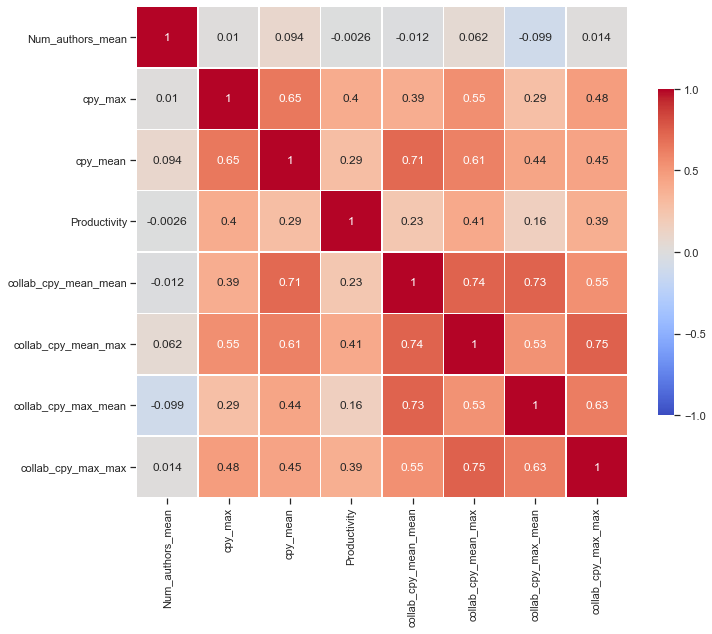

In [20]:
corr_matrix = X.corr()

f, ax = plt.subplots(figsize=(11, 15)) 
heatmap = sns.heatmap(corr_matrix,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [6]:
def score_CV(model, metric):
    score = cross_val_score(model, X, y, cv=5, scoring=metric)
    print(score)
    print('mean:', np.mean(score))

In [39]:
logreg = LogisticRegression(solver='newton-cg', C=0.5)
score_CV(logreg, 'accuracy')

[0.83729829 0.84328731 0.83494176 0.84159734 0.84442596]
mean: 0.8403101302631255


In [46]:
rf = RandomForestClassifier(n_estimators=50, random_state=0)
score_CV(rf, 'accuracy')

[0.86923973 0.87922143 0.87703827 0.88053245 0.88469218]
mean: 0.87814480994494


In [48]:
boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=50, random_state=0)
score_CV(boost, 'accuracy')

[0.89619032 0.89951755 0.88968386 0.89400998 0.89434276]
mean: 0.8947488949128483
